# Capítulo 7 — Fundamentos teóricos e simulações

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.3/578.3 kB 10.9 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Centróide calculado (Sigma A): -3.33+0.00j


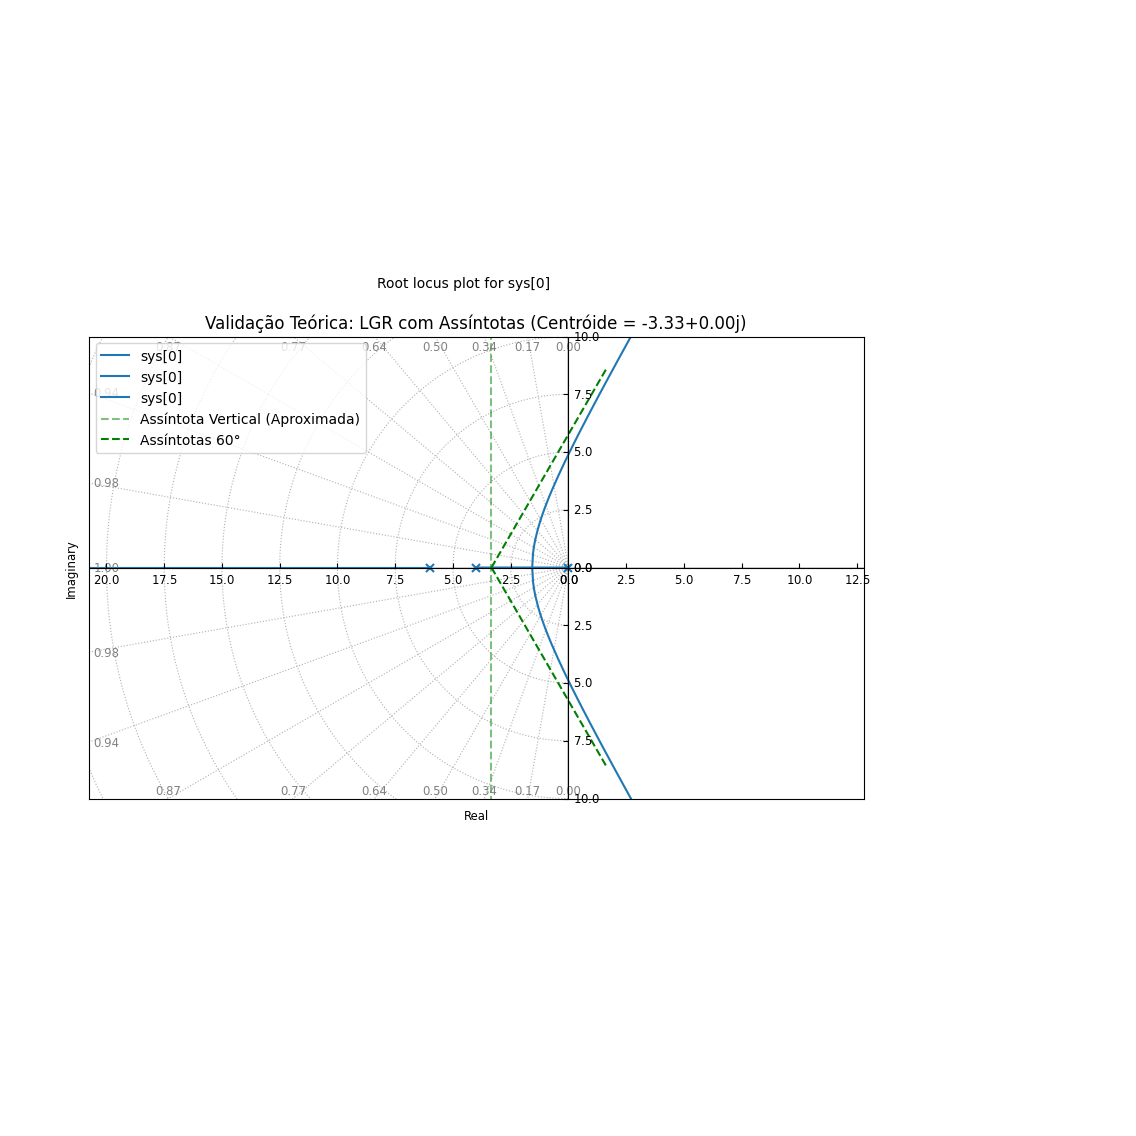

In [1]:
# --- CÓDIGO TEÓRICO: LGR E ASSÍNTOTAS ---
!pip install control
import control as ct
import matplotlib.pyplot as plt
import numpy as np

# 1. Definir o Sistema (3 polos, 0 zeros -> 3 assíntotas)
# G(s) = 1 / [s(s+4)(s+6)] = 1 / (s^3 + 10s^2 + 24s)
num = [1]
den = [1, 10, 24, 0]
sys = ct.tf(num, den)

# 2. Cálculo Teórico (Conforme Livro Cap 7)
polos = ct.poles(sys)
zeros = ct.zeros(sys)
n = len(polos)
m = len(zeros)

# Centróide (Ponto de encontro das assíntotas no eixo real)
sigma_a = (np.sum(polos) - np.sum(zeros)) / (n - m)
print(f"Centróide calculado (Sigma A): {sigma_a:.2f}")

# 3. Plotagem
plt.figure(figsize=(10, 6))

# Plota o Lugar das Raízes (biblioteca)
ct.root_locus(sys, grid=True)

# Desenha as Assíntotas Manualmente (Teoria)
# Para 3 ramos, ângulos são 60°, 180°, 300° (-60°)
assintota_x = [sigma_a, sigma_a + 10] # Linha base
assintota_y1 = [0, 10 * np.tan(np.deg2rad(60))]  # +60 graus
assintota_y2 = [0, 10 * np.tan(np.deg2rad(-60))] # -60 graus

# Plota as linhas das assíntotas
plt.plot([sigma_a, sigma_a], [-15, 15], 'g--', alpha=0.5, label='Assíntota Vertical (Aproximada)')
plt.plot([sigma_a, sigma_a+5], [0, 5*1.73], 'g--', label='Assíntotas 60°')
plt.plot([sigma_a, sigma_a+5], [0, -5*1.73], 'g--')

plt.title(f"Validação Teórica: LGR com Assíntotas (Centróide = {sigma_a:.2f})")
plt.legend()
plt.ylim(-10, 10)
plt.xlim(-10, 2)
plt.show()

# O Efeito do Ganho na Resposta no Tempo

Mostrar a conexão "Lugar das Raízes -> Resposta ao Degrau". Este script escolhe três pontos no LGR (Ganho Baixo, Médio e Alto) e plota como o robô/sistema se comportaria na vida real. É a essência do controle.

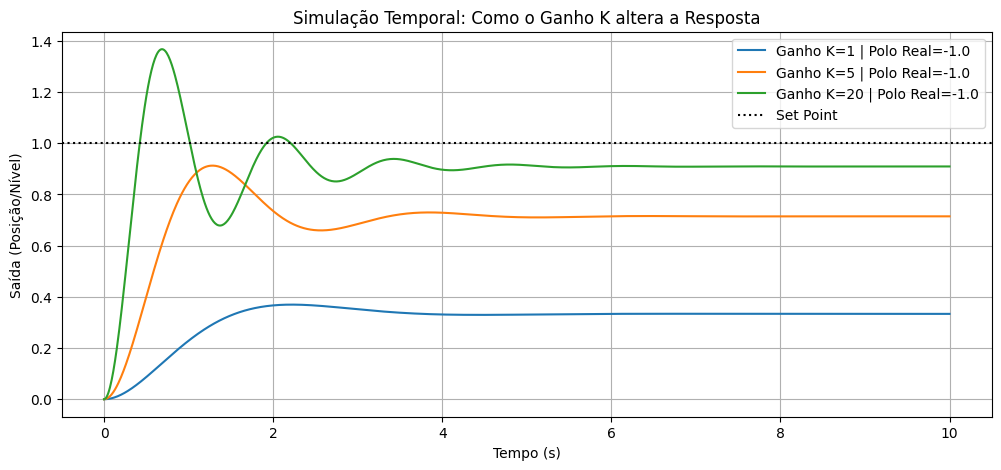

In [2]:
# --- CÓDIGO SIMULAÇÃO: O IMPACTO DO GANHO K ---
import control as ct
import matplotlib.pyplot as plt
import numpy as np

# Sistema: G(s) = 1 / (s^2 + 2s + 2)  (Já é oscilatório)
sys_open = ct.tf([1], [1, 2, 2])

# Três valores de Ganho K para teste
ganhos = [1, 5, 20]
t = np.linspace(0, 10, 1000)

plt.figure(figsize=(12, 5))

# Loop para simular cada ganho
for K in ganhos:
    # Cria o sistema em malha fechada T(s) = KG / (1 + KG)
    sys_closed = ct.feedback(K * sys_open, 1)

    # Calcula os polos deste sistema específico
    polos = ct.poles(sys_closed)
    parte_real = np.real(polos[0])

    # Simula a resposta ao degrau (Set Point = 1)
    t_out, y_out = ct.step_response(sys_closed, T=t)

    # Plota
    plt.plot(t_out, y_out, label=f'Ganho K={K} | Polo Real={parte_real:.1f}')

plt.title("Simulação Temporal: Como o Ganho K altera a Resposta")
plt.xlabel("Tempo (s)")
plt.ylabel("Saída (Posição/Nível)")
plt.axhline(1, color='k', linestyle=':', label='Set Point')
plt.grid()
plt.legend()
plt.show()

Note que aumentar o ganho $K$ aumenta a frequência de oscilação e o sobressinal (Overshoot), exatamente como previsto pelo fato das raízes subirem verticalmente no plano $s$.

# Encontrando o Ganho Crítico ($K_{crit}$)

Objetivo: Calcular computacionalmente o ponto exato onde o sistema se torna instável (cruza o eixo imaginário). Isso substitui o cálculo manual de Routh-Hurwitz.

--- ANÁLISE DE ESTABILIDADE ---
O sistema torna-se instável com Ganho K >= 0.00
Localização dos polos na instabilidade: [-4.+0.j -2.+0.j  0.+0.j]


/usr/local/lib/python3.12/dist-packages/control/rlocus.py:202: FutureWarning: root_locus() return value of roots, gains is deprecated; use root_locus_map()
  warnings.warn(


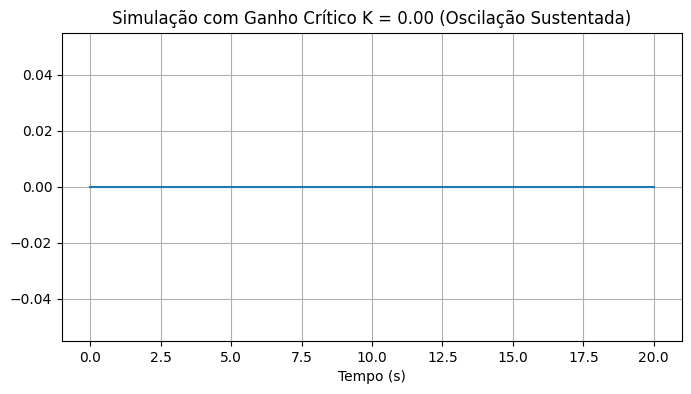

In [3]:
# --- CÓDIGO DE ANÁLISE: ENCONTRANDO A INSTABILIDADE ---
import control as ct
import numpy as np

# Sistema de 3ª ordem instável para ganhos altos
# G(s) = 1 / s(s+2)(s+4)
sys = ct.tf([1], [1, 6, 8, 0])

# 1. Obter dados do Locus (sem plotar)
# Usamos plot=False para pegar os dados numéricos
rlist, klist = ct.root_locus(sys, plot=False)

# 2. Varredura para achar onde a parte real cruza zero
k_critico = 0
polo_instavel = 0

# Percorre todos os ganhos calculados
for i, ganho in enumerate(klist):
    # Verifica se algum polo tem parte real > -0.01 (praticamente zero)
    polos_atuais = rlist[i]
    if np.max(np.real(polos_atuais)) >= -0.001:
        k_critico = ganho
        polo_instavel = polos_atuais
        break

print(f"--- ANÁLISE DE ESTABILIDADE ---")
print(f"O sistema torna-se instável com Ganho K >= {k_critico:.2f}")
print(f"Localização dos polos na instabilidade: {polo_instavel}")

# 3. Prova Real: Simular com o ganho crítico
sys_limite = ct.feedback(k_critico * sys, 1)
t, y = ct.step_response(sys_limite, T=np.linspace(0, 20, 1000))

plt.figure(figsize=(8, 4))
plt.plot(t, y)
plt.title(f"Simulação com Ganho Crítico K = {k_critico:.2f} (Oscilação Sustentada)")
plt.xlabel("Tempo (s)")
plt.grid()
plt.show()